# COVID-19 in SPAIN

Done by: Aitor del Rio

Official Data Source: https://www.mscbs.gob.es/

Official Data in pdf (2020-03-03 to Today):

Official Data in .csv (2020-03-03 to Today):

    1) COVID19_SPA.csv the data correspond to the whole of the Spanish State. 
    2) COVID19_SPA_AC.csv the data has been classified by Autonomous Communities (Regions).

## Dataset Info

Each dataset contains 9 columns: 

* **Region**
* **Date**
* <sup>1</sup> **Total** : Total Confirmed Cases. 
* <sup>2</sup> **AI(14d)** : Accumulated Incidence in the last 14 days.
* <sup>3 </sup><sup>4</sup> **Hospitalized**
* <sup>4</sup> **ICU**
* <sup>3</sup> **Deads** 
* <sup>3</sup> **Recovered** 
* **New** : New Confirmed Cases

<sup>1</sup> The Total Confirmed Cases do not come from the sum of Hospitalized, Recovered and Dead patients, since they are not exclusive.

<sup>2</sup> AI: Accumulated incidence (cases accumulated per 100,000 inhabitants).

<sup>3</sup> Dead and Recovered patients may have been hospitalized and therefore compute in both
groups. 

<sup>4</sup> Patients who have required ICU also compute in patients who have been hospitalized.


In [1]:
%matplotlib inline
import pandas as pd
import matplotlib
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
from IPython.display import display, HTML
from datetime import datetime
style.use('ggplot')

In [2]:
filename='/home/pi/Documents/juno/covid_spa_data/COVID19_SPA'
df_s=pd.read_csv(filepath_or_buffer=filename,parse_dates = True)
df_s.set_index(['Region', 'Date'], inplace=True)
df_s.sort_index(inplace=True)
#display(df_s) #Comment to generate pdf

In [3]:
filename='/home/pi/Documents/juno/covid_spa_data/COVID19_SPA_AC'
df_ac=pd.read_csv(filepath_or_buffer=filename,parse_dates = True)
df_ac.set_index(['Region', 'Date'], inplace=True)
df_ac.sort_index(inplace=True)
#display(df_ac) #Comment to generate pdf

### COVID19 in the Spanish State

Data Visualization of COVID19_SPA.csv

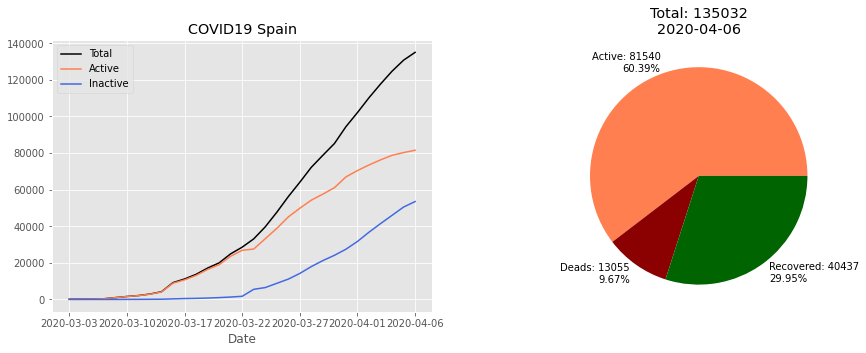

In [4]:
#COVID19 Total-Active-Inactive
df_s['Inactive']=((df_s['Recovered']).fillna(0)+(df_s['Deads']).fillna(0))[0:]
df_s['Active']=((df_s['Total']).fillna(0)-(df_s['Inactive']).fillna(0))[0:]

#COVID19 Today (%)
today=((df_s.reset_index()).loc[[len(df_s)-1]]).reset_index()
#Percentages
tt=today['Active'][0]+today['Deads'][0]+today['Recovered'][0]
ta=round((today['Active'][0]/tt)*100,2)
td=round((today['Deads'][0]/tt)*100,2)
tr=round((today['Recovered'][0]/tt)*100,2)
today_cases=pd.DataFrame({'Total':[today['Active'][0],today['Deads'][0],today['Recovered'][0]]},index=['Active: '+str(int(today['Active'][0]))+'\n'+str(ta)+'%','Deads: '+str(int(today['Deads'][0]))+'\n'+str(td)+'%','Recovered: '+str(int(today['Recovered'][0]))+'\n'+str(tr)+'%'])


#Plotting DataFrame Sub-Plots
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
df_s.fillna(0).reset_index().plot(ax=axes[0],x='Date',y=['Total','Active','Inactive'],color=['k','coral','royalblue'],grid=True)
axes[0].set_title('COVID19 Spain')
today_cases.plot.pie(ax=axes[1],y='Total',colors=['coral','darkred','darkgreen'],legend=False)
axes[1].set_title('Total: '+str(today['Total'][0]) +'\n'+str(today['Date'][0]))
axes[1].set_ylabel(' ')
plt.show()

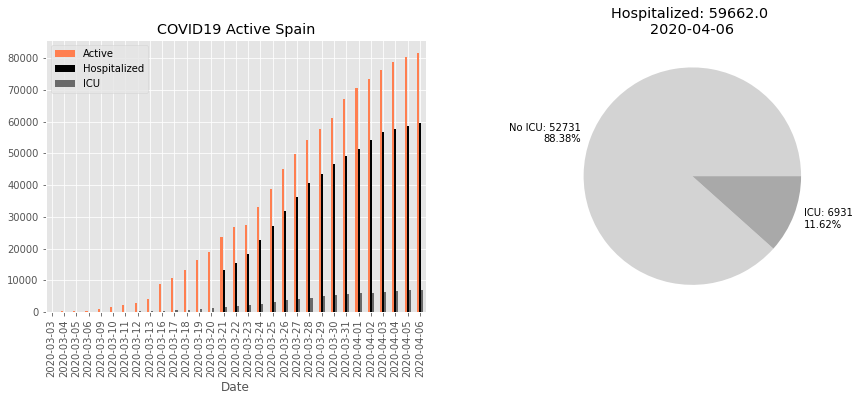

In [5]:
#COVID19 Today (%)
today=((df_s.reset_index()).loc[[len(df_s)-1]]).reset_index()
today['No ICU']=today['Hospitalized'][0]-today['ICU'][0]
#Percentages
tt=today['Hospitalized'][0]
ti=round((today['ICU'][0]/tt)*100,2)
tni=round((today['No ICU'][0]/tt)*100,2)

today_hsp=pd.DataFrame({'Hospitalized':[today['No ICU'][0],today['ICU'][0]]},index=['No ICU: '+str(int(today['No ICU'][0]))+'\n'+str(tni)+'%','ICU: '+str(int(today['ICU'][0]))+'\n'+str(ti)+'%'])

#Plotting DataFrame Sub-Plots
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
df_s.fillna(0).reset_index().plot.bar(ax=axes[0],x='Date',y=['Active','Hospitalized','ICU'],color=['coral','k','dimgray'],grid=True)
axes[0].set_title('COVID19 Active Spain')
today_hsp.plot.pie(ax=axes[1],y='Hospitalized',colors=['lightgray','darkgray'],legend=False)
axes[1].set_title('Hospitalized: '+str(today['Hospitalized'][0])+' \n'+str(today['Date'][0]))
axes[1].set_ylabel(' ')
plt.show()



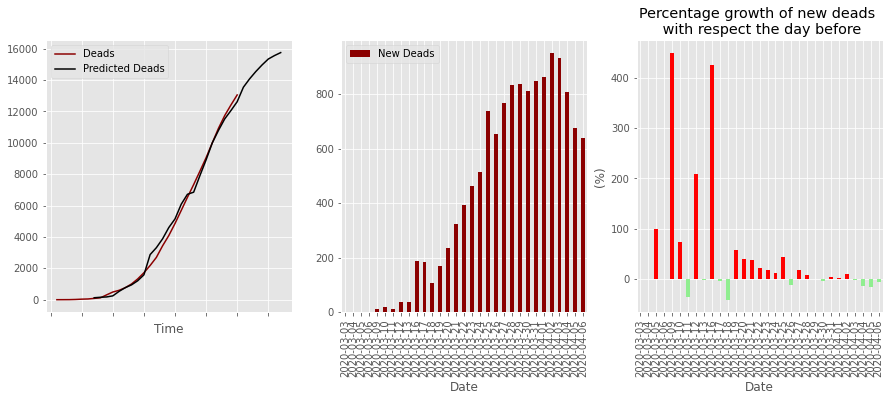

In [6]:
ip=7#Disease outcome period

#Building a Prediction Model for Deads
idf=df_s.reset_index()
x=[]
for el in idf.loc[0:len(idf)-1-ip,'Active']:
    x.append(el)
y=[]
for el in idf.loc[0+ip:len(idf),'Deads']:
    y.append(el)
pp=np.polyfit(np.log(x), np.log(y), 1, w=np.sqrt(y))#Prediction parameters


#Plot Predicted Deads
idf=df_s.reset_index()
x=[]
for el in idf.loc[:,'Active']:
    x.append(el)
y=[]
for el in idf.loc[:,'Deads']:
    y.append(el)
    
p= list(np.exp(pp[1]) * np.exp(pp[0] * np.log(x))) #Prediction

for i in range(ip):       
    x.append(float('nan'))
    y.append(float('nan'))
    p.insert(0,float('nan'))

mdd=pd.DataFrame({'Active':x,'Deads':y,'Predicted Deads':p})

d_1=0
nwd=[]
for d in (df_s['Deads']).fillna(0):
    nwd.append(d-d_1)
    d_1=d
df_s['New Deads']=nwd
g_1=0
gr=[]
for g in df_s['New Deads']:
    if(g_1==0):
        gr.append(0)
    else:
        gr.append(((g-g_1)/g_1)*100)
    g_1=g
df_s['New Deads Growth Rate']=gr 

fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(15,5))

mdd.reset_index().plot(ax=axes[0], y=['Deads','Predicted Deads'],color=['darkred','k'],grid=True)
axes[0].set_xticklabels([])
axes[0].set_xlabel('Time')
df_s.fillna(0).reset_index().plot.bar(ax=axes[1],x='Date',color='darkred',y=['New Deads'],grid=True)
idf=df_s
idf['sign'] = df_s['New Deads Growth Rate']> 0
(idf.reset_index('Region'))['New Deads Growth Rate'].plot(kind='bar',color=idf.sign.map({True:'red',False:'lightgreen'}))
axes[2].set_ylabel('(%)')
axes[2].set_title('Percentage growth of new deads \n with respect the day before')

plt.show()

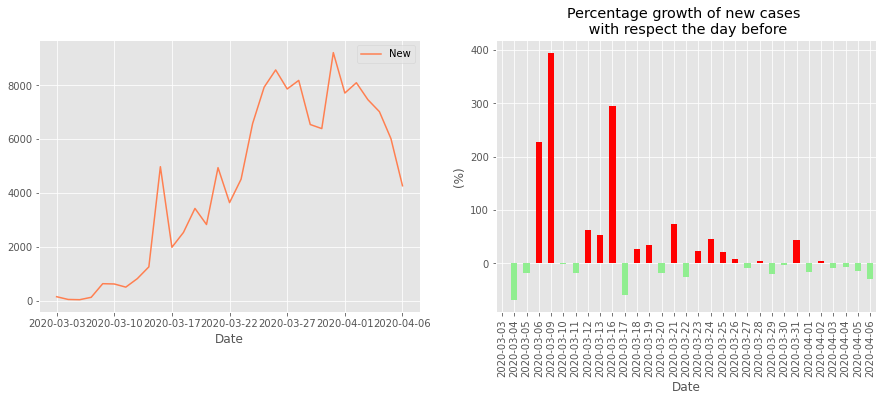

In [7]:
t_1=0
nw=[]
for t in df_s['Total']:
    nw.append(t-t_1)
    t_1=t
df_s['New']=nw
g_1=0
gr=[]
for g in df_s['New']:
    if(g_1==0):
        gr.append(0)
    else:
        gr.append(((g-g_1)/g_1)*100)
    g_1=g
df_s['New Cases Growth Rate']=gr    
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
df_s.fillna(0).reset_index().plot(ax=axes[0],x='Date',color='coral',y=['New'],grid=True)

idf=df_s
idf['sign'] = df_s['New Cases Growth Rate']> 0
(idf.reset_index('Region'))['New Cases Growth Rate'].plot(kind='bar',color=idf.sign.map({True:'red',False:'lightgreen'}))
axes[1].set_ylabel('(%)')
axes[1].set_title('Percentage growth of new cases \n with respect the day before')
plt.show()

### Percentage growth of new cases 
* $i$, day
* $N_i$, new cases on day $i$ 
* Percentage growth of new cases, $\frac{N_{i}-N_{i-1}}{N_{i-1}}100 (\%)$

Notable changes in the percentage growth of reported new cases:
 * 2020-03-06 
    + **+228.2%** more new cases than on 2020-03-05.
 * 2020-03-07  **No Data**.
 * 2020-03-08  **No Data**.
 * 2020-03-09 
    + **+395.3%** more new cases than on 2020-03-06. 
 * 2020-03-14
    + **Lockdown measures are implemented**
 * 2020-03-16
    + **+295.7%** more new cases than on 2020-03-15.
    

### COVID19 in the Basque Country
Data Visualization of COVID19_SPA_AC.csv

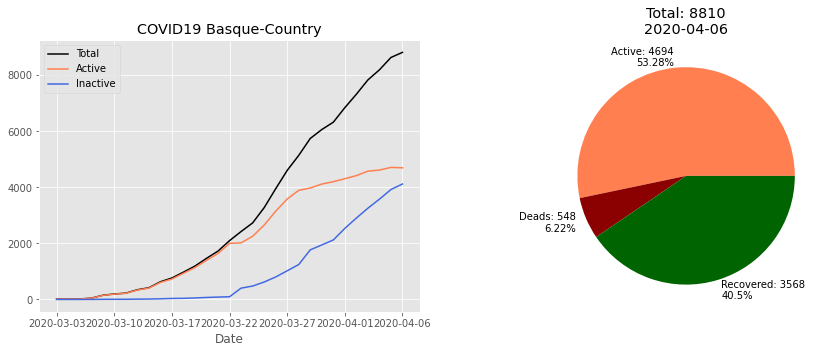

In [8]:
df_eh=(df_ac.loc['País-Vasco',:]).reset_index()
#COVID19 Total-Active-Inactive
df_eh['Inactive']=((df_eh['Recovered']).fillna(0)+(df_eh['Deads']).fillna(0))[0:]
df_eh['Active']=((df_eh['Total']).fillna(0)-(df_eh['Inactive']).fillna(0))[0:]

#COVID19 Today (%)
today=((df_eh.reset_index()).loc[[len(df_eh)-1]]).reset_index()
#Percentages
tt=today['Active'][0]+today['Deads'][0]+today['Recovered'][0]
ta=round((today['Active'][0]/tt)*100,2)
td=round((today['Deads'][0]/tt)*100,2)
tr=round((today['Recovered'][0]/tt)*100,2)
today_cases=pd.DataFrame({'Total':[today['Active'][0],today['Deads'][0],today['Recovered'][0]]},index=['Active: '+str(int(today['Active'][0]))+'\n'+str(ta)+'%','Deads: '+str(int(today['Deads'][0]))+'\n'+str(td)+'%','Recovered: '+str(int(today['Recovered'][0]))+'\n'+str(tr)+'%'])


#Plotting DataFrame Sub-Plots
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
df_eh.fillna(0).reset_index().plot(ax=axes[0],x='Date',y=['Total','Active','Inactive'],color=['k','coral','royalblue'],grid=True)
axes[0].set_title('COVID19 Basque-Country')
today_cases.plot.pie(ax=axes[1],y='Total',colors=['coral','darkred','darkgreen'],legend=False)
axes[1].set_title('Total: '+str(today['Total'][0]) +'\n'+str(today['Date'][0]))
axes[1].set_ylabel(' ')
plt.show()

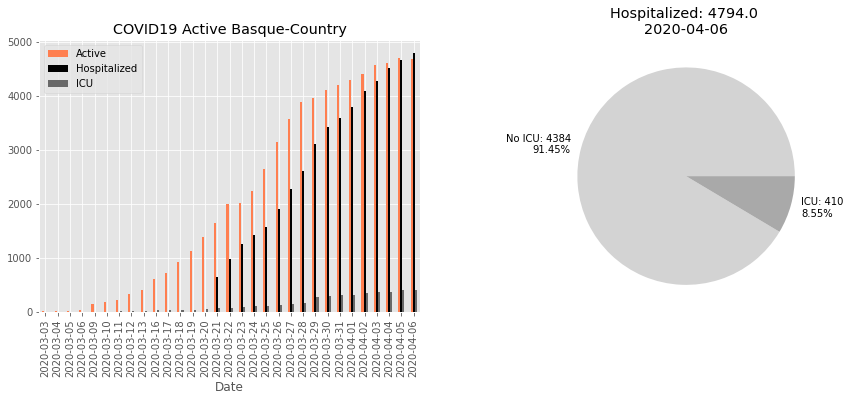

In [9]:
#COVID19 Today (%)
today=((df_eh.reset_index()).loc[[len(df_eh)-1]]).reset_index()
today['No ICU']=today['Hospitalized'][0]-today['ICU'][0]
#Percentages
tt=today['Hospitalized'][0]
ti=round((today['ICU'][0]/tt)*100,2)
tni=round((today['No ICU'][0]/tt)*100,2)

today_hsp=pd.DataFrame({'Hospitalized':[today['No ICU'][0],today['ICU'][0]]},index=['No ICU: '+str(int(today['No ICU'][0]))+'\n'+str(tni)+'%','ICU: '+str(int(today['ICU'][0]))+'\n'+str(ti)+'%'])

#Plotting DataFrame Sub-Plots
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
df_eh.fillna(0).reset_index().plot.bar(ax=axes[0],x='Date',y=['Active','Hospitalized','ICU'],color=['coral','k','dimgray'],grid=True)
axes[0].set_title('COVID19 Active Basque-Country')
today_hsp.plot.pie(ax=axes[1],y='Hospitalized',colors=['lightgray','darkgray'],legend=False)
axes[1].set_title('Hospitalized: '+str(today['Hospitalized'][0])+' \n'+str(today['Date'][0]))
axes[1].set_ylabel(' ')
plt.show()

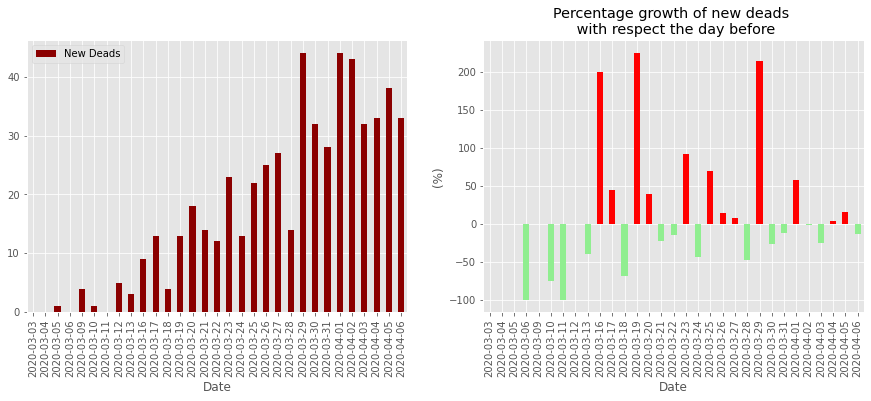

In [10]:
d_1=0
nwd=[]
for d in (df_eh['Deads']).fillna(0):
    nwd.append(d-d_1)
    d_1=d
df_eh['New Deads']=nwd
g_1=0
gr=[]
for g in df_eh['New Deads']:
    if(g_1==0):
        gr.append(0)
    else:
        gr.append(((g-g_1)/g_1)*100)
    g_1=g
df_eh['New Deads Growth Rate']=gr    
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
df_eh.fillna(0).reset_index().plot.bar(ax=axes[0],x='Date',color='darkred',y=['New Deads'],grid=True)

idf=df_eh
idf['sign'] = df_eh['New Deads Growth Rate']> 0
(idf.set_index('Date'))['New Deads Growth Rate'].plot(kind='bar',color=idf.sign.map({True:'red',False:'lightgreen'}))
axes[1].set_ylabel('(%)')
axes[1].set_title('Percentage growth of new deads \n with respect the day before')
plt.show()

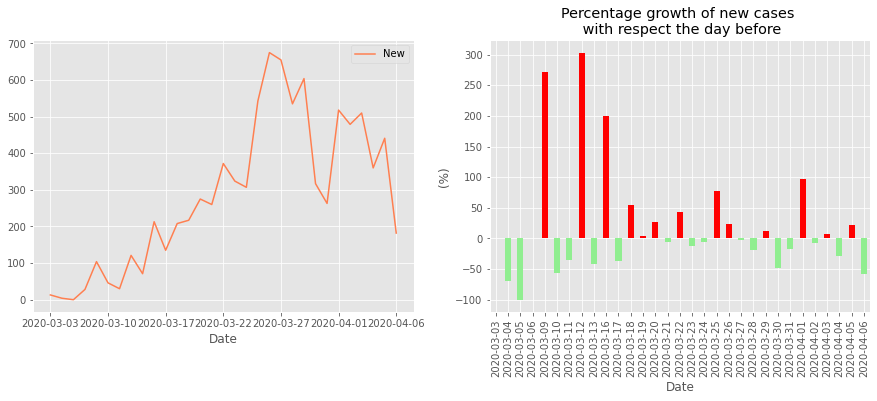

In [11]:
t_1=0
nw=[]
for t in df_eh['Total']:
    nw.append(t-t_1)
    t_1=t
df_eh['New']=nw
g_1=0
gr=[]
for g in df_eh['New']:
    if(g_1==0):
        gr.append(0)
    else:
        gr.append(((g-g_1)/g_1)*100)
    g_1=g
df_eh['New Cases Growth Rate']=gr    
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
df_eh.fillna(0).reset_index().plot(ax=axes[0],x='Date',color='coral',y=['New'],grid=True)

idf=df_eh
idf['sign'] = df_eh['New Cases Growth Rate']> 0
(idf.set_index('Date'))['New Cases Growth Rate'].plot(kind='bar',color=idf.sign.map({True:'red',False:'lightgreen'}))
axes[1].set_ylabel('(%)')
axes[1].set_title('Percentage growth of new cases \n with respect the day before')
plt.show()

### COVID19 compare regions 

Autonomous Communities:

['Andalucía', 'Aragón', 'Asturias', 'Baleares', 'Canarias', 'Cantabria', 'Castilla-La-Mancha', 'Castilla-y-León', 'Cataluña', 'Ceuta', 'C-Valenciana', 'Extremadura', 'Galicia', 'Madrid', 'Melilla', 'Murcia', 'Navarra', 'País-Vasco', 'La-Rioja']

In [12]:
#Selected regions
#rg=['País-Vasco','Navarra','Cantabria']#'Cataluña','Madrid'
rg=['Andalucía', 'Aragón', 'Asturias', 'Baleares', 'Canarias', 'Cantabria', 'Castilla-La-Mancha', 'Castilla-y-León', 'Cataluña', 'Ceuta', 'C-Valenciana', 'Extremadura', 'Galicia', 'Madrid', 'Melilla', 'Murcia', 'Navarra', 'País-Vasco', 'La-Rioja']
#COVID19 Total-Active-Inactive
df_ac['Inactive']=((df_ac['Recovered']).fillna(0)+(df_ac['Deads']).fillna(0))[0:]
df_ac['Active']=((df_ac['Total']).fillna(0)-(df_ac['Inactive']).fillna(0))[0:]
df_ac['P Recovered in Total']=(((df_ac['Recovered']).fillna(0)/df_ac['Total'])*100).fillna(0)
df_ac['P Deads in Total']=(((df_ac['Deads']).fillna(0)/df_ac['Total'])*100).fillna(0)

##Plotting DataFrame Sub-Plots
#fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(15,5))
#(df_ac.loc[rg,:]).reset_index().pivot('Date','Region','Active').plot(ax=axes[0])
#axes[0].tick_params(axis='x', rotation=45)
#axes[0].set_title('COVID19 Active')
#axes[0].set_xlabel(' ')

##(df_ac.loc[rg,:]).reset_index().pivot('Date','Region','Deads').plot(ax=axes[1])
##axes[1].tick_params(axis='x', rotation=45)
##axes[1].set_title('COVID19 Deads')
#(df_ac.loc[rg,:]).reset_index().pivot('Date','Region','P Recovered in Total').plot(ax=axes[1])
#axes[1].tick_params(axis='x', rotation=45)
#axes[1].set_title('% of Recovered over Total Cases\n in the region')
#axes[1].set_xlabel(' ')

#(df_ac.loc[rg,:]).reset_index().pivot('Date','Region','P Deads in Total').plot(ax=axes[2])
#axes[2].tick_params(axis='x', rotation=45)
#axes[2].set_title('% of Deads from Total Cases\n in the region')
#axes[2].set_xlabel(' ')
#plt.show()

In an attempt to stop COVID19, **loockdown** measures were stablished the 2020-3-14. Since then, COVID19 is hitting the society and its **Universal Health-Care System** severelly.
The Political-&-Administrative model in Spain delegates to the Autonomous Communities the management of the Health-Care System in each region. Thus, analysing and comparing the progress of the COVID19 pandemia by Autonomous Communities makes sense.

* The **% of Inactive Cases over Total Cases in the region** gives a measure about **how close** an Autonomous Community is to defeat COVID19. While **high** percentages indicate that the Autonomous Communities are about to end with COVID19, **low** percentages show the opposite. In any case, this values are only a *proximity* indicator towards the end of the COVID19 crisis and **can not be used to state how well Autonomous Communities Health-Care Systems are dealing with the infected population**.


* The **% of Recovered&Deads over Inactive Cases in the region** shows a picture of the Recovered-Dead ratio over Inactive cases at the present moment. This values must be treated just as "objetive-data" and **can not be used to compare how well or how badly Autonomous Communities Health-Care Systems are dealing with the infected population** since the scope of COVID19-Scenario differs in a large amount from region to region.


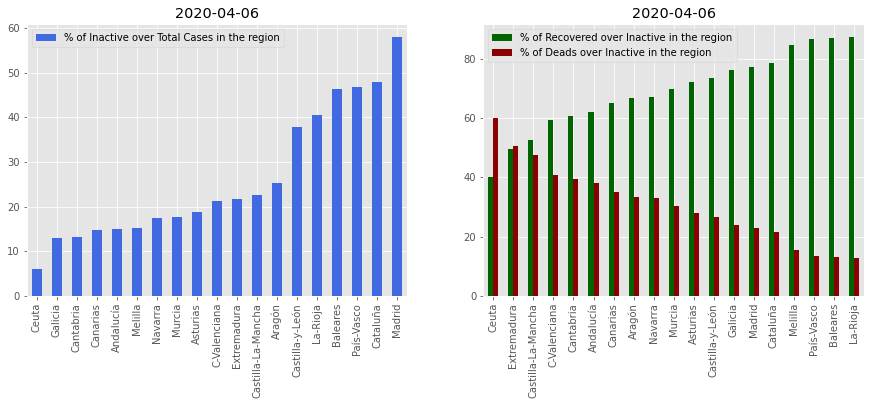

In [13]:

#Get Today Data
idf=df_ac.reset_index()
dates=[]
for date in idf['Date']:
    dates.append(date)
idf.set_index(['Date'], inplace=True)
idf.sort_index(inplace=True)
##dataFrame.loc[<ROWS RANGE> , <COLUMNS RANGE>]
today=idf.loc[dates[len(dates)-1],:]
today=today.reset_index('Date')

#Data to be ploted

today['% of Inactive over Total Cases in the region']=((today['Inactive']/today['Total'])*100)
today['% of Recovered over Inactive in the region']=(((today['Recovered']).fillna(0)/today['Inactive'])*100).fillna(0)
today['% of Deads over Inactive in the region']=(((today['Deads']).fillna(0)/today['Inactive'])*100).fillna(0)

fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
today=today.sort_values(by='% of Inactive over Total Cases in the region')
today.plot.bar(ax=axes[0],x='Region',y=['% of Inactive over Total Cases in the region'],color=['royalblue'],grid=True)
axes[0].set_xlabel('')
axes[0].set_ylabel('')
axes[0].set_title(str(dates[len(dates)-1]))

today=today.sort_values(by='% of Recovered over Inactive in the region')
today.plot.bar(ax=axes[1],x='Region',y=['% of Recovered over Inactive in the region','% of Deads over Inactive in the region'],color=['darkgreen','darkred'],grid=True)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_title(str(dates[len(dates)-1]))
plt.show()

In order to understand the graph bellow watch: https://www.youtube.com/watch?v=54XLXg4fYsc

In [14]:
#rg=['Andalucía', 'Aragón', 'Asturias', 'Baleares', 'Canarias', 'Cantabria', 'Castilla-La-Mancha', 'Castilla-y-León', 'Cataluña', 'Ceuta', 'C-Valenciana', 'Extremadura', 'Galicia', 'Madrid', 'Melilla', 'Murcia', 'Navarra', 'País-Vasco', 'La-Rioja']
#x=[]
#y=[]
#fig, axes = plt.subplots(nrows=2,ncols=1,figsize=(10,15))
#for aut_co in rg:
#    df_aut_co=(df_ac.loc[aut_co,:]).reset_index()
#    t_1=0
#    nw=[]
#    for t in df_aut_co['Total']:
#        nw.append(t-t_1)
#        t_1=t
#    df_aut_co['New']=nw

#    df_aut_co.reset_index().plot(ax=axes[0],x='Total',y='New',label=aut_co,grid=True)
#    axes[0].set_ylabel('New cases')
#    axes[0].set_yscale('log')
#    axes[0].set_xscale('log')
    
#    x_i=(today.set_index('Region')).loc[aut_co,'Total']
#    y_i=(today.set_index('Region')).loc[aut_co,'New']
#    x.append(x_i)
#    y.append(y_i)
    
#    axes[0].scatter(x_i,y_i,marker='o')
#    axes[0].text(x_i+0.3,y_i+0.3,aut_co,fontsize=9)

#for i,rgs in enumerate(rg):
#    x_coords=x[i]
#    y_coords=y[i]
#    axes[1].scatter(x_coords,y_coords,marker='o')
#    axes[1].text(x_coords+0.3,y_coords+0.3,rgs,fontsize=9)
#axes[1].set_ylabel('New cases')
#axes[1].set_yscale('log')
#axes[1].set_xscale('log')

#axes[0].set_title('From 2020-03-03 '+'to '+str(dates[len(dates)-1]))
#axes[1].set_title('Today ('+str(dates[len(dates)-1])+')')    
#plt.savefig('mf.pdf')
#plt.show()

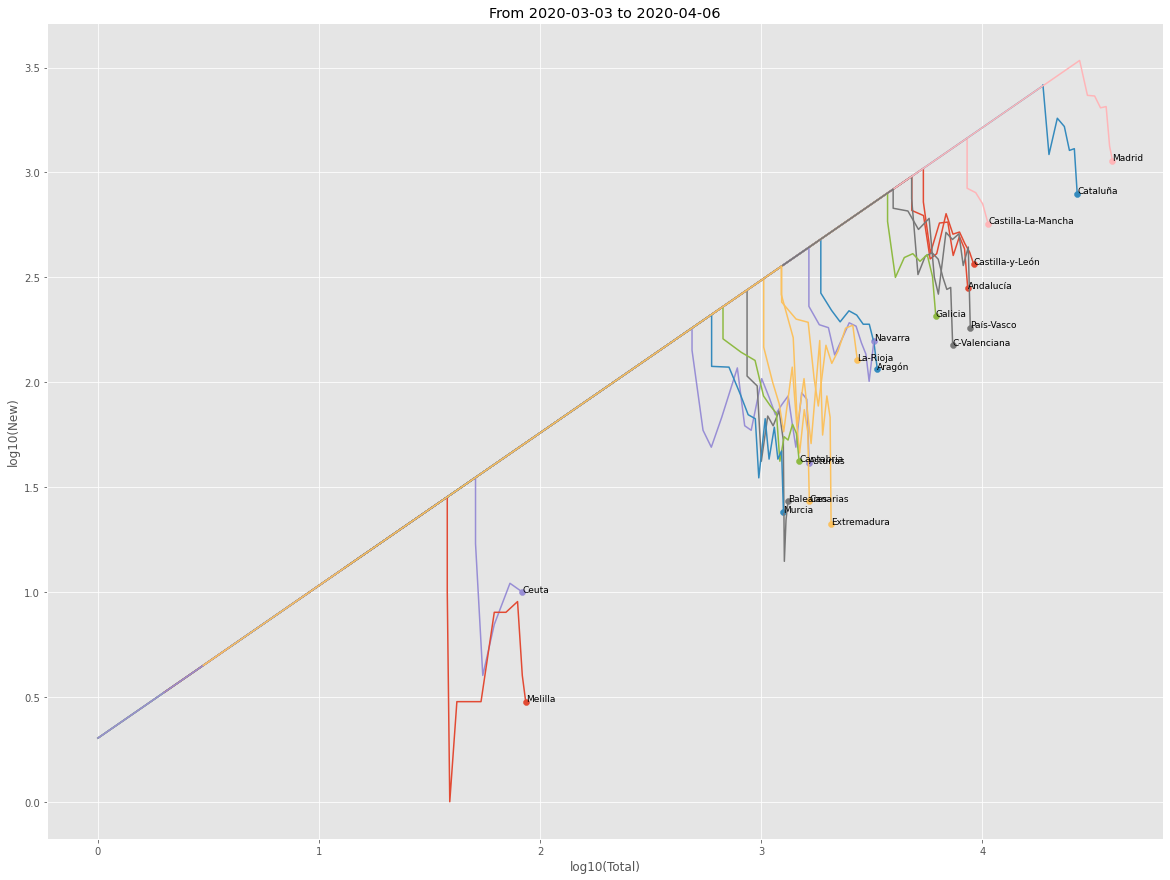

In [14]:
rg=['Andalucía', 'Aragón', 'Asturias', 'Baleares', 'Canarias', 'Cantabria', 'Castilla-La-Mancha', 'Castilla-y-León', 'Cataluña', 'Ceuta', 'C-Valenciana', 'Extremadura', 'Galicia', 'Madrid', 'Melilla', 'Murcia', 'Navarra', 'País-Vasco', 'La-Rioja']
x=[]
y=[]
sup_x=[]
sup_y=[]
#fig, axes = plt.subplots(nrows=2,ncols=1,figsize=(20,15))
plt.figure(figsize=(20,15))
for aut_co in rg:
    df_aut_co=(df_ac.loc[aut_co,:]).reset_index()
    t_1=0
    nw=[]
    tl=[]
    for t in df_aut_co['Total']:
        tl.append(t)
        nw.append(t-t_1)
        t_1=t
    df_aut_co['New']=nw

    #Remove zeros
    nnw=[]
    ttl=[]
    for i in range(len(nw)):
        if nw[i]!=0:
             nnw.append(nw[i])
             ttl.append(tl[i])
        
    #Linear regresion        
    y=[nnw[0],max(nnw)]
    x=[ttl[0],ttl[nnw.index(max(nnw))]]               
    #pp=np.polyfit(np.log10(x),np.log10(y),1)#linearfit parameters
    sup_x.append(x[0])
    sup_x.append(x[1])
    sup_y.append(y[0])
    sup_y.append(y[1])
    
    #line=list(pp[0]*np.log10(x)+pp[1]);
    #yy=line+list(np.log10(nnw[nnw.index(max(nnw)):]))
    #xx=list(np.log10(x))+list(np.log10(ttl[nnw.index(max(nnw)):]))
    #axes[0].plot(xx,yy)

#Super Regresion
xxx=[sup_x[0],max(sup_x)]
yyy=[sup_y[0],sup_y[sup_x.index(max(sup_x))]]
super_pp=np.polyfit(np.log10(xxx),np.log10(yyy),1)#linearfit parameters
for aut_co in rg:
    df_aut_co=(df_ac.loc[aut_co,:]).reset_index()
    t_1=0
    nw=[]
    tl=[]
    for t in df_aut_co['Total']:
        tl.append(t)
        nw.append(t-t_1)
        t_1=t
    df_aut_co['New']=nw

    #Remove zeros
    nnw=[]
    ttl=[]
    for i in range(len(nw)):
        if nw[i]!=0:
             nnw.append(nw[i])
             ttl.append(tl[i])
            
    y=[nnw[0],max(nnw)]
    x=[ttl[0],ttl[nnw.index(max(nnw))]] 
    
    line=list(super_pp[0]*np.log10(x)+super_pp[1]);
    yy=line+list(np.log10(nnw[nnw.index(max(nnw)):]))
    xx=list(np.log10(x))+list(np.log10(ttl[nnw.index(max(nnw)):]))
    plt.plot(xx,yy)

    x_i=xx[len(xx)-1]
    y_i=yy[len(yy)-1]
    plt.scatter(x_i,y_i,marker='o')
    plt.text(x_i,y_i,aut_co,fontsize=9)
plt.title('From 2020-03-03 '+'to '+str(dates[len(dates)-1]))
plt.ylabel('log10(New)')
plt.xlabel('log10(Total)')
plt.savefig('mf1.pdf')
plt.show()   


In [23]:
#for ii in range(17):
#    rg=['Andalucía', 'Aragón', 'Asturias', 'Baleares', 'Canarias', 'Cantabria', 'Castilla-La-Mancha', 'Castilla-y-León', 'Cataluña', 'Ceuta', 'C-Valenciana', 'Extremadura', 'Galicia', 'Madrid', 'Melilla', 'Murcia', 'Navarra', 'País-Vasco', 'La-Rioja']
#    x=[]
#    y=[]
#    sup_x=[]
#    sup_y=[]
#    #fig, axes = plt.subplots(nrows=2,ncols=1,figsize=(20,15))
#    plt.figure(figsize=(20,15))
#    for aut_co in rg:
#        df_aut_co=(df_ac.loc[aut_co,:]).reset_index()
#        df_aut_co=df_aut_co.loc[0:len(df_aut_co)-1-ii,:]
#        t_1=0
#        nw=[]
#        tl=[]
#        for t in df_aut_co['Total']:
#            tl.append(t)
#            nw.append(t-t_1)
#            t_1=t
#        df_aut_co['New']=nw

#        #Remove zeros
#        nnw=[]
#        ttl=[]
#        for i in range(len(nw)):
#            if nw[i]!=0:
#                 nnw.append(nw[i])
#                 ttl.append(tl[i])
        
#        #Linear regresion        
#        y=[nnw[0],max(nnw)]
#        x=[ttl[0],ttl[nnw.index(max(nnw))]]               
#        #pp=np.polyfit(np.log10(x),np.log10(y),1)#linearfit parameters
#        sup_x.append(x[0])
#        sup_x.append(x[1])
#        sup_y.append(y[0])
#        sup_y.append(y[1])
    
#        #line=list(pp[0]*np.log10(x)+pp[1]);
#        #yy=line+list(np.log10(nnw[nnw.index(max(nnw)):]))
#        #xx=list(np.log10(x))+list(np.log10(ttl[nnw.index(max(nnw)):]))
#        #axes[0].plot(xx,yy)

#    #Super Regresion
#    xxx=[sup_x[0],max(sup_x)]
#    yyy=[sup_y[0],sup_y[sup_x.index(max(sup_x))]]
#    super_pp=np.polyfit(np.log10(xxx),np.log10(yyy),1)#linearfit parameters
#    for aut_co in rg:
#        df_aut_co=(df_ac.loc[aut_co,:]).reset_index()
#        df_aut_co=df_aut_co.loc[0:len(df_aut_co)-1-ii,:]
#        t_1=0
#        nw=[]
#        tl=[]
#        for t in df_aut_co['Total']:
#            tl.append(t)
#            nw.append(t-t_1)
#            t_1=t
#        df_aut_co['New']=nw

#        #Remove zeros
#        nnw=[]
#        ttl=[]
#        for i in range(len(nw)):
#            if nw[i]!=0:
#                 nnw.append(nw[i])
#                 ttl.append(tl[i])
            
#        y=[nnw[0],max(nnw)]
#        x=[ttl[0],ttl[nnw.index(max(nnw))]] 
    
#        line=list(super_pp[0]*np.log10(x)+super_pp[1]);
#        yy=line+list(np.log10(nnw[nnw.index(max(nnw)):]))
#        xx=list(np.log10(x))+list(np.log10(ttl[nnw.index(max(nnw)):]))
#        plt.plot(xx,yy)

#        x_i=xx[len(xx)-1]
#        y_i=yy[len(yy)-1]
#        plt.scatter(x_i,y_i,marker='o')
#        plt.text(x_i,y_i,aut_co,fontsize=9)
#        plt.xlim([0,np.log10(100000)])
#        plt.ylim([0,np.log10(10000)])
#    plt.title('From 2020-03-03 '+'to '+str(dates[len(dates)-1-ii]))
#    plt.ylabel('log10(New)')
#    plt.xlabel('log10(Total)')
#    plt.savefig('mf1'+str(dates[len(dates)-1-ii])+'.jpg')
#    plt.show()  

In [22]:
#import imageio
#images=[]
#for ii in range(17):
#    ii
#    images.append(imageio.imread('/home/pi/Documents/juno/'+'mf1'+str(dates[len(dates)-1-ii])+'.jpg'))
#i=16
#images2=[]
#for img in images:
#    images2.append(images[i])
#    i-=1
#imageio.mimsave('/home/pi/Documents/juno/movie2.gif',images2,fps='0.1')